# Unsupervised learning with DBSCAN

In [6]:
from pymongo import MongoClient
from gensim.models import Word2Vec
import gensim
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import networkx as nx
from itertools import combinations
import community
from collections import defaultdict
import randomcolor
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import pickle
from scipy.special import comb
from scipy.spatial.distance import pdist
from sklearn.cluster import DBSCAN

## Load reduced-dim vector

### 86-dimension vectors 

In [2]:
reduced_86D_vectors = pickle.load(open("86D_threshhold_pca_features.p", 'rb'))

In [3]:
drop_index = np.argwhere(np.isnan(reduced_86D_vectors))
drop_row_index = drop_index[:,0]

In [4]:
reduced_86D_vectors = pd.DataFrame(reduced_86D_vectors)
reduced_86D_vectors = reduced_86D_vectors.dropna()
reduced_86D_vectors.shape

(11235, 86)

## DBSCAN 

### DBSCAN on reduced 86-dimension vectors 

In [7]:
def dbscan_GridSearch(pcafeatures, eps_min, eps_max, n_steps):

    db_clusters = []
    db_noise = []
    eps_list = []

    # Run eps range from minimum to maximum pairwise distance in the dataset
    # not sure how to define the num metric: set to 10 now, can set it as an argument later
    eps_range = np.linspace(eps_min, eps_max, endpoint=True, num=n_steps)

    print('Moving closer to upper bound of epsilon where # clusters is 1\n')
    
    print('------', '\nExploring epsilon range between', eps_min, 'and', eps_max)


    for i in eps_range:
        if db_clusters.count(1) < 2:
            print('Evaluating', i)
            db = DBSCAN(eps=i, min_samples=2, metric='cosine').fit(pcafeatures)

            core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
            core_samples_mask[db.core_sample_indices_] = True
            labels = db.labels_

            # Number of clusters in labels, ignoring noise if present.
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
            db_clusters.append(n_clusters_)

            n_noise_ = np.count_nonzero(db.labels_ == -1)
            db_noise.append(n_noise_)

            eps_list.append(i)
        
    if db_clusters.count(1) > 1: 
        print('\nReached epsilon giving clusters = 1')
        eps_max = eps_list[-db_clusters.count(1)]
        return dbscan_GridSearch(pcafeatures, eps_min, eps_max, n_steps)
    print('------\nNumber of clusters\n', db_clusters, '\n------\nNumber of noise points:\n', db_noise)

    return db, eps_list, db_noise, db_clusters

In [8]:
cosine_pdist = pdist(reduced_86D_vectors, metric='cosine')

In [9]:
eps_min = min(i for i in cosine_pdist if i > 0)
eps_max = max(cosine_pdist)

#### Explore the space 

In [11]:
db, eps_list, db_noise, db_clusters = dbscan_GridSearch(reduced_86D_vectors, eps_min, eps_max, 10)

Moving closer to upper bound of epsilon where # clusters is 1

------ 
Exploring epsilon range between 1.11022302463e-16 and 1.71363744549
Evaluating 1.11022302463e-16
Evaluating 0.19040416061
Evaluating 0.38080832122
Evaluating 0.57121248183
Evaluating 0.76161664244

Reached epsilon giving clusters = 1
Moving closer to upper bound of epsilon where # clusters is 1

------ 
Exploring epsilon range between 1.11022302463e-16 and 0.57121248183
Evaluating 1.11022302463e-16
Evaluating 0.0634680535367
Evaluating 0.126936107073
Evaluating 0.19040416061
Evaluating 0.253872214147
Evaluating 0.317340267683
Evaluating 0.38080832122
Evaluating 0.444276374757
Evaluating 0.507744428293
Evaluating 0.57121248183
------
Number of clusters
 [604, 1094, 939, 657, 361, 159, 53, 13, 3, 1] 
------
Number of noise points:
 [9153, 6755, 5048, 3441, 2070, 1054, 396, 81, 9, 0]


In [14]:
db = DBSCAN(eps=eps_list[3], min_samples=4, metric='cosine').fit(reduced_86D_vectors)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

n_noise_ = np.count_nonzero(db.labels_ == -1)

print(n_clusters_, n_noise_)

161 4621


### Match cluster labels to individual criteria in 86-dim space

Link 'winning' cluster labels to individual criteria and studies.

In [28]:
def connect_to_mongo(database, collection):
    
    """
    Opens a connection to a specified Mongo DB location
    
    Input Parameters:
    database: name of database to connect to or create (str)
    collection: name of collection to connect to or create (str)
    
    Returns:
    The connection object for the database without a collection specified
    The connection object for a specific Mongo location (database & collection)
    """
    
    client = MongoClient()
    db = client[database]
    mongo_loc = db[collection]
    return db, mongo_loc

In [29]:
trials_loc, eligibility_loc = connect_to_mongo('clinical_trials', 'eligibilities')

In [30]:
doc_cursor = eligibility_loc.find({"inclusion_criteria": { '$regex' : ".*asthma.*"}})

study_id = []
inclusion_text = []

for study in doc_cursor:
    for crit in study['cleaned_inclusion']:
        study_id.append(study['study_id'])
        inclusion_text.append(crit)
print(len(study_id))

11298


In [62]:
len(labels)

11235

Remove study ids from criteria that were dropped due to having NaN

In [32]:
drop_row_list = pickle.load(open("drop_row_list.p", 'rb'))

In [33]:
for i in sorted(drop_row_list, reverse=True):
    del study_id[i]
    del inclusion_text[i]

In [34]:
len(np.unique(study_id))

2155

In [35]:
len(study_id)

11235

In [36]:
study_id_array = np.array(study_id).reshape(11235,1)

In [37]:
study_id_array

array([['NCT00861185'],
       ['NCT00861185'],
       ['NCT00861185'],
       ..., 
       ['NCT00867737'],
       ['NCT00867737'],
       ['NCT00867737']], 
      dtype='<U11')

In [38]:
inclusion_text_array = np.array(inclusion_text).reshape(11235,1)

In [41]:
clusts = labels.reshape(11235,1)

In [42]:
crit_studies_clusters = np.hstack((clusts, study_id_array))
print(crit_studies_clusters)

[['0' 'NCT00861185']
 ['1' 'NCT00861185']
 ['0' 'NCT00861185']
 ..., 
 ['0' 'NCT00867737']
 ['0' 'NCT00867737']
 ['0' 'NCT00867737']]


In [43]:
crit_df = pd.DataFrame(crit_studies_clusters)
crit_df.columns = ['cluster', 'study_id']

In [44]:
crit_df.head()

,cluster,study_id
0,0,NCT00861185
1,1,NCT00861185
2,0,NCT00861185
3,0,NCT00861185
4,-1,NCT00861185


In [45]:
mask = (~crit_df['cluster'].isin(['0', '-1']))
crit_df = crit_df[mask]

## Format for network plot with criteria as nodes: 86-dim DBSCAN clusters

In [46]:
crit_group = crit_df.groupby(by='study_id')['cluster'].apply(tuple)

In [47]:
crit_network_input = np.array(crit_group)

In [48]:
crit_network_input

array([('13',), ('2',), ('90',), ..., ('5',), ('39',),
       ('95', '96', '10', '97', '98', '99', '100', '101', '102')], dtype=object)

In [49]:
combinations(crit_network_input[0], 2)

In [50]:
network_input = []
for crit in crit_network_input:
    results = [x for x in combinations(crit, 2)]
    network_input += (results)

In [52]:
network_input[:10]

[('28', '51'),
 ('28', '29'),
 ('51', '29'),
 ('2', '2'),
 ('28', '51'),
 ('28', '29'),
 ('51', '29'),
 ('28', '51'),
 ('28', '29'),
 ('51', '29')]

## Make network plot: nodes are eligibility criteria

In [53]:
trials = nx.Graph()

In [54]:
for crit_1, crit_2 in network_input:
    trials.add_edge(crit_1, crit_2)

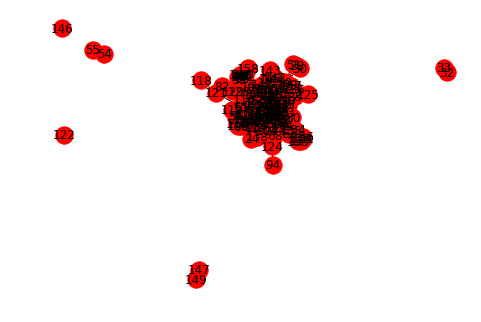

In [55]:
positions = nx.spring_layout(trials)
network = nx.draw(trials, pos=positions)
labels =  nx.draw_networkx_labels(trials, pos=positions)

In [56]:
nx.density(trials)

0.046183339142558386

In [57]:
nx.degree(trials)

DegreeView({'28': 3, '51': 2, '29': 5, '2': 69, '74': 9, '17': 29, '1': 21, '56': 4, '26': 7, '5': 40, '89': 13, '25': 7, '3': 68, '23': 12, '107': 9, '87': 8, '88': 8, '75': 14, '13': 5, '72': 5, '73': 5, '11': 23, '39': 19, '18': 15, '125': 1, '31': 7, '58': 6, '84': 4, '6': 7, '47': 3, '14': 15, '80': 1, '64': 15, '57': 5, '79': 5, '77': 1, '76': 3, '41': 5, '21': 4, '22': 17, '36': 3, '16': 6, '90': 10, '69': 9, '70': 9, '71': 9, '38': 4, '27': 3, '104': 5, '83': 10, '19': 5, '8': 8, '66': 3, '65': 3, '160': 4, '12': 2, '50': 3, '42': 6, '45': 6, '59': 4, '4': 4, '54': 1, '55': 3, '52': 12, '37': 6, '63': 5, '15': 4, '53': 3, '93': 3, '49': 6, '48': 7, '46': 4, '44': 7, '7': 4, '35': 7, '124': 2, '111': 12, '43': 6, '32': 1, '33': 1, '34': 8, '30': 2, '123': 7, '20': 2, '9': 6, '151': 6, '60': 6, '10': 11, '158': 1, '155': 3, '156': 3, '157': 3, '112': 1, '113': 13, '86': 6, '81': 6, '103': 4, '85': 3, '152': 3, '149': 1, '147': 3, '40': 8, '154': 3, '159': 1, '92': 3, '68': 3, '67

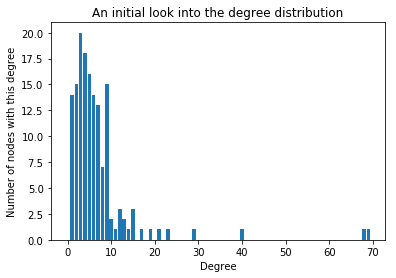

In [58]:
degree_hist = nx.degree_histogram(trials)
xticks = range(len(degree_hist))
plt.bar(xticks, degree_hist, align='center')
plt.xlabel('Degree')
plt.ylabel('Number of nodes with this degree')
plt.title('An initial look into the degree distribution');

## Format for network plot with studies as nodes 

In [59]:
crit_group_study_node = crit_df.groupby(by='cluster')['study_id'].apply(tuple)

In [60]:
crit_network_input_study_node = np.array(crit_group_study_node)

In [61]:
network_input_study_nodes = []
for crit in crit_network_input_study_node:
    results = [x for x in combinations(crit, 2)]
    network_input_study_nodes += (results)

In [62]:
network_input_study_nodes[:5]

[('NCT00861185', 'NCT00861211'),
 ('NCT00861185', 'NCT00819676'),
 ('NCT00861185', 'NCT00785668'),
 ('NCT00861185', 'NCT00770315'),
 ('NCT00861185', 'NCT00783198')]

### Identifying communities in the criteria network 

In [63]:
modules = community.best_partition(trials)

In [64]:
module_ids = set(modules.values())
num_modules = len(module_ids)
num_modules

14

### Identify which criteria are in each community

In [65]:
module_to_nodes = defaultdict(list)
for node, module_id in modules.items():
    module_to_nodes[module_id].append(node)

# module_to_nodes[4]

### Plot the criteria network graph with communities 

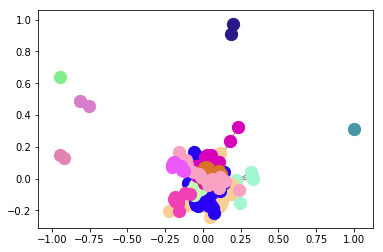

In [66]:
positions = nx.spring_layout(trials)

rand_color = randomcolor.RandomColor()
colors = rand_color.generate(count=num_modules)
for i, module in enumerate(module_ids):
    nodes_in_this_module = module_to_nodes[module]
    module_color = colors[i % len(colors)]
    nx.draw_networkx_nodes(trials,
                           positions,
                           nodes_in_this_module,
                           node_color = module_color,
                           node_size = 150)
nx.draw_networkx_edges(trials, positions, alpha=0.5)
# labels =  nx.draw_networkx_labels(study_nodes, pos=positions)

## Network graph: trials as nodes 

In [67]:
# study_nodes = nx.Graph()

In [68]:
# for trial_1, trial_2 in network_input_study_nodes:
#     study_nodes.add_edge(trial_1, trial_2)

In [69]:
default_weight = 1
study_nodes = nx.Graph()
for nodes in network_input_study_nodes:
    n0 = nodes[0]
    n1 = nodes[1]
    if study_nodes.has_edge(n0,n1):   
        study_nodes[n0][n1]['weight'] += default_weight
    else:
        study_nodes.add_edge(n0,n1, weight=default_weight)

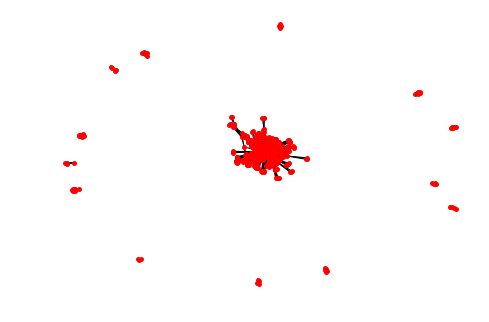

In [75]:
positions = nx.spring_layout(study_nodes)
network = nx.draw(study_nodes, pos=positions, node_size = 15)
# labels =  nx.draw_networkx_labels(study_nodes, pos=positions)

In [76]:
nx.write_gexf(study_nodes, "86D_DBSCAN_criteria_nodes.gexf")

In [77]:
neighbor_weights = study_nodes['NCT00862394']

In [78]:
# print(neighbor_weights)

In [79]:
nx.density(study_nodes)

0.11726914957387474

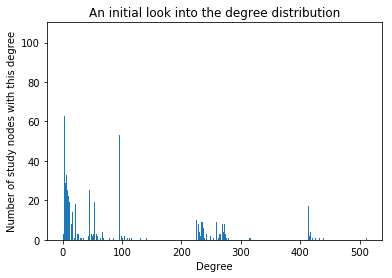

In [80]:
degree_hist = nx.degree_histogram(study_nodes)
xticks = range(len(degree_hist)) # adjust range and widths
plt.bar(xticks, degree_hist, align='center')
plt.xlabel('Degree')
plt.ylabel('Number of study nodes with this degree')
plt.title('An initial look into the degree distribution');

### Identifying communities in the network 

In [81]:
modules = community.best_partition(study_nodes)

In [82]:
module_ids = set(modules.values())
num_modules = len(module_ids)
num_modules

25

### Identify which criteria are in each community

In [83]:
module_to_nodes = defaultdict(list)
for node, module_id in modules.items():
    module_to_nodes[module_id].append(node)

# module_to_nodes[0]

### Plot the criteria network graph with communities 

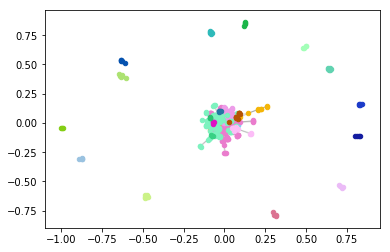

In [84]:
positions = nx.spring_layout(study_nodes)

rand_color = randomcolor.RandomColor()
colors = rand_color.generate(hue='random', count=num_modules)
for i, module in enumerate(module_ids):
    nodes_in_this_module = module_to_nodes[module]
    module_color = colors[i % len(colors)]
    nx.draw_networkx_nodes(trials,
                           positions,
                           nodes_in_this_module,
                           node_color = module_color,
                           node_size = 20)
nx.draw_networkx_edges(study_nodes, positions, alpha=0.1)
# labels =  nx.draw_networkx_labels(study_nodes, pos=positions)

In [85]:
nx.write_gexf(study_nodes, "86D_DBSCAN_trial_nodes.gexf")